In [ ]:
!pip install mne seaborn -q

import os
import numpy as np
import random

import mne
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from scipy.signal import welch

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 34.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Folder containing S001R01.edf, S001R02.edf, ...
DATA_DIR = "/content/drive/MyDrive/eeg_eyes_project"  # change if needed

print(f"Files in {DATA_DIR} (first 10):")
print(os.listdir(DATA_DIR)[:10])

# Window length in seconds (2s works better than 1s for RF/KNN)
WINDOW_SEC = 2.0


Files in /content/drive/MyDrive/eeg_eyes_project (first 10):
['S001R01.edf', 'S001R02.edf', 'S002R01.edf', 'S002R02.edf', 'S003R01.edf', 'S003R02.edf', 'S004R01.edf', 'S004R02.edf', 'S005R01.edf', 'S005R02.edf']


In [ ]:
def bandpower(signal, sf, band):
    """
    Compute log bandpower of 'signal' in frequency 'band' using Welch's PSD.
    band = (fmin, fmax)
    """
    fmin, fmax = band
    freqs, psd = welch(signal, sf, nperseg=256)
    idx = (freqs >= fmin) & (freqs <= fmax)
    return np.log(np.trapz(psd[idx], freqs[idx]) + 1e-12)


def multiband_features(windows, sfreq):
    """
    windows: (n_win, n_chan, n_samples)
    returns: (n_win, n_chan * n_bands)
    Bands: delta, theta, alpha, beta
    """
    bands = {
        "delta": (1, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "beta":  (13, 30)
    }

    n_win, n_chan, n_samples = windows.shape
    n_bands = len(bands)
    X = np.zeros((n_win, n_chan * n_bands), dtype=float)

    for i in range(n_win):
        feats = []
        for ch in range(n_chan):
            sig = windows[i, ch, :]
            for b in bands.values():
                feats.append(bandpower(sig, sfreq, b))
        X[i] = feats

    return X


In [ ]:
def extract_features_from_file_optimized(file_path, label, window_sec=WINDOW_SEC):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

    # Keep EEG channels only
    raw.pick_types(eeg=True)
    ch_names = raw.info["ch_names"]
    n_chan = len(ch_names)

    raw.set_eeg_reference('average', projection=False, verbose=False)
    raw.filter(1., 40., fir_design='firwin', verbose=False)

    data = raw.get_data()
    sfreq = raw.info["sfreq"]

    n_samples_per_win = int(window_sec * sfreq)
    total = data.shape[1]
    n_windows = total // n_samples_per_win
    if n_windows == 0:
        return None, None, None

    data = data[:, :n_windows * n_samples_per_win]
    data = data.reshape(n_chan, n_windows, n_samples_per_win)
    windows = np.transpose(data, (1, 0, 2))

    # MULTIBAND FEATURES
    X_feats = multiband_features(windows, sfreq)

    y_feats = np.full(X_feats.shape[0], label, dtype=int)

    # Return channel names once (same per EDF)
    return X_feats, y_feats, ch_names


In [ ]:
def build_dataset_optimized(data_dir, window_sec=WINDOW_SEC):
    X_list, y_list = [], []
    feature_names = None
    collected_ch_names = None

    files = sorted(glob(os.path.join(data_dir, "*.edf")))
    print("Found", len(files), "EDF files")

    for fpath in files:
        fname = os.path.basename(fpath)
        if "R01" in fname:
            label = 0
        elif "R02" in fname:
            label = 1
        else:
            continue

        print("Processing", fname, "label =", label)

        X_feats, y_feats, ch_names = extract_features_from_file_optimized(
            fpath, label, window_sec
        )

        if X_feats is None:
            print("  -> Skipping short file")
            continue

        X_list.append(X_feats)
        y_list.append(y_feats)

        # Save the channel names only once
        if collected_ch_names is None:
            collected_ch_names = ch_names

    # STACK
    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    # BUILD FEATURE NAME LIST: channel × 4 bands
    bands = ["delta", "theta", "alpha", "beta"]
    feature_names = []
    for ch in collected_ch_names:
        for b in bands:
            feature_names.append(f"{ch}_{b}")

    print("Final X shape:", X.shape)
    print("Final y shape:", y.shape)
    print("Class counts:", np.bincount(y))
    print("First 10 feature names:", feature_names[:10])

    return X, y, feature_names


# --- Build dataset ---
X, y, feature_names = build_dataset_optimized(DATA_DIR, window_sec=WINDOW_SEC)


Found 100 EDF files
Processing S001R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1446760867.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.log(np.trapz(psd[idx], freqs[idx]) + 1e-12)


Processing S001R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S002R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S002R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S003R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S003R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S004R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S004R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S005R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S005R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=SEED,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))


Train shape: (2250, 256) Test shape: (750, 256)
Train class counts: [1125 1125]
Test class counts: [375 375]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_base = RandomForestClassifier(
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced"    # helps if classes aren’t perfectly equal
)

param_dist = {
    "n_estimators":      [200, 300, 400, 500],
    "max_depth":         [None, 20, 40, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best CV accuracy:", rf_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60}
Best CV accuracy: 0.8475555555555556


In [ ]:
rf_best = rf_search.best_estimator_

y_pred_rf = rf_best.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest test accuracy: {acc:.10f}")

print("\nRandom Forest classification report:\n",
      classification_report(y_test, y_pred_rf))


Random Forest test accuracy: 0.8760000000

Random Forest classification report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       375
           1       0.89      0.86      0.87       375

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750



                  Pred: Open (0)  Pred: Closed (1)
True: Open (0)               334                41
True: Closed (1)              52               323


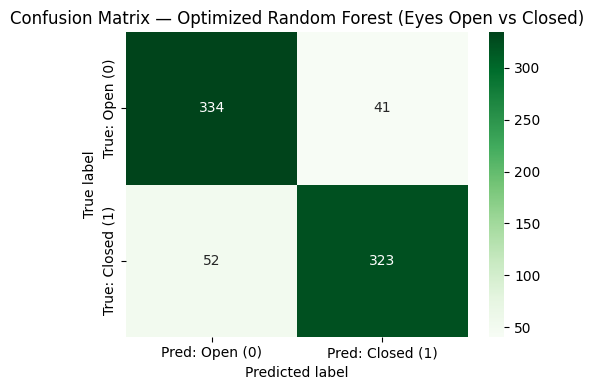

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

import pandas as pd

cm_rf_df = pd.DataFrame(
    cm_rf,
    index=["True: Open (0)", "True: Closed (1)"],
    columns=["Pred: Open (0)", "Pred: Closed (1)"]
)

print(cm_rf_df)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf_df, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Optimized Random Forest (Eyes Open vs Closed)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


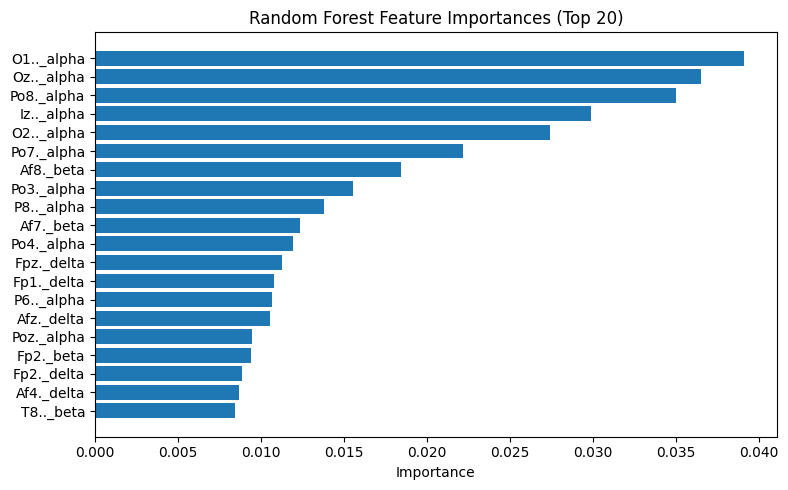

In [ ]:
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20
top_idx = indices[:top_k]
top_names = [feature_names[i] for i in top_idx]
top_values = importances[top_idx]

plt.figure(figsize=(8, 5))
plt.barh(top_names[::-1], top_values[::-1])   # reverse so biggest on top
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances (Top 20)")
plt.tight_layout()
plt.show()


In [ ]:
best_params = rf_search.best_params_

# Handle None depth cleanly
depth_str = ("unlimited depth"
             if best_params["max_depth"] is None
             else f"max_depth = {best_params['max_depth']}")

print(
    f"The optimized Random Forest uses {best_params['n_estimators']} trees, "
    f"{depth_str}, min_samples_split = {best_params['min_samples_split']}, "
    f"min_samples_leaf = {best_params['min_samples_leaf']}, and "
    f"max_features = '{best_params['max_features']}'."
)


The optimized Random Forest uses 400 trees, max_depth = 60, min_samples_split = 5, min_samples_leaf = 1, and max_features = 'sqrt'.


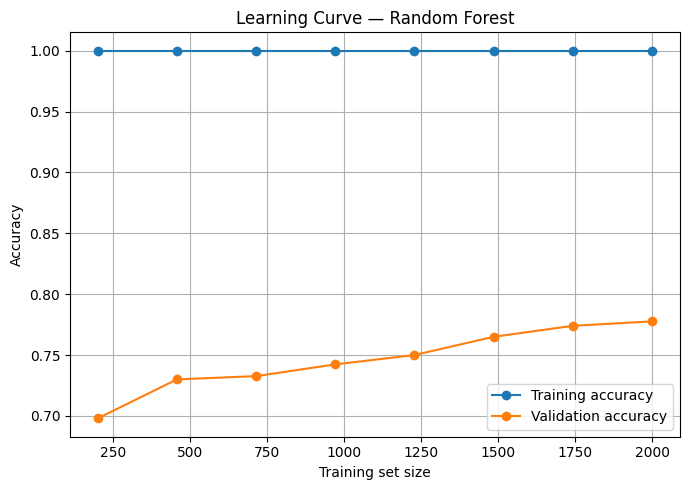

In [ ]:
# learning curve

from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    rf_best,
    X,
    y,
    cv=3,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label="Training accuracy")
plt.plot(train_sizes, test_mean, 'o-', label="Validation accuracy")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve — Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


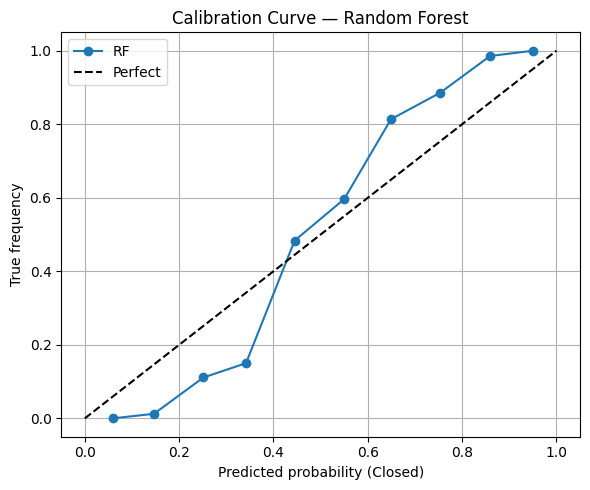

In [ ]:
# calibration curve
from sklearn.calibration import calibration_curve

y_proba = rf_best.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, "o-", label="RF")
plt.plot([0,1], [0,1], "k--", label="Perfect")
plt.xlabel("Predicted probability (Closed)")
plt.ylabel("True frequency")
plt.title("Calibration Curve — Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


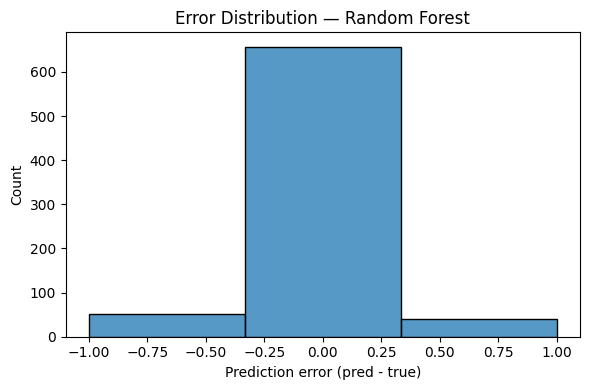

In [ ]:
# False Positive & False Negative distributions
# Compute prediction errors FIRST
errors = y_pred_rf - y_test

# Now plot
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=3, kde=False)
plt.xlabel("Prediction error (pred - true)")
plt.ylabel("Count")
plt.title("Error Distribution — Random Forest")
plt.tight_layout()
plt.show()
